# Homework assignment 4

In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.signal import detrend
from obspy.signal.detrend import polynomial
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm

## Task 1.1

In [267]:
df = pd.read_csv("Miles.csv", index_col="DATE", parse_dates=["DATE"])
df

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0
...,...
2023-09-01,278073.0
2023-10-01,284151.0
2023-11-01,265178.0


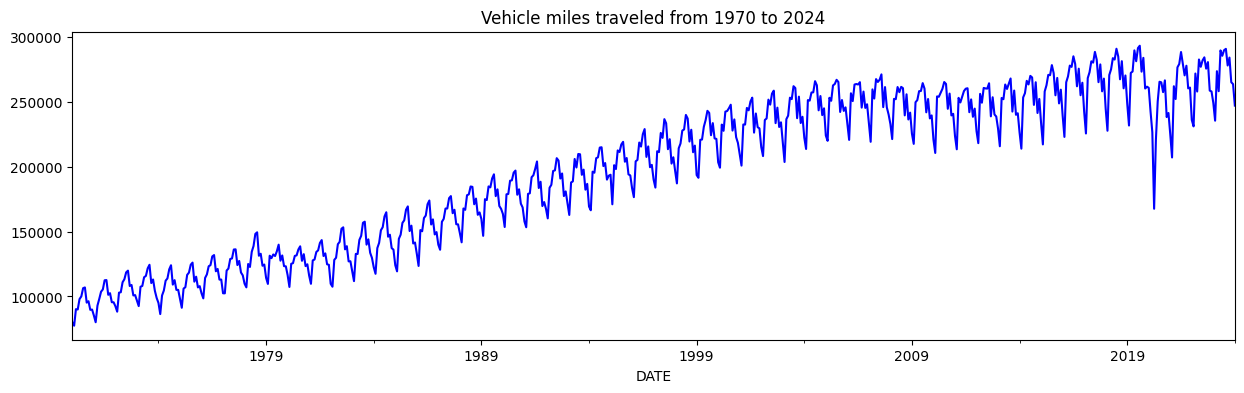

In [268]:
df["TRFVOLUSM227NFWA"].plot(figsize=(15,4), color="blue")
plt.title("Vehicle miles traveled from 1970 to 2024")
plt.show()

To define whether our data has a trend, firstly, we need to identify what the trend is. Trend is the tendency of data to increase or to decrease in a long period of time. As we can see in plot of the vehicles miles traveled, the number of miles driven is growing every year, so we can say that our data has a trend

## Task 1.2

To predict the vehicle miles traveled in month $t$, given data in month $t-1$, intuintively, detrended data will be better, because we make a prediction in short-term. However to construct final conclusion, we need to understand difference between raw data and detrended data.

**Raw data**
- Retain all information without any changes;
- Can be useful to catch the short-term changes, if the trend remains stable during all period of time;

**Detrended data**
- Can catch short-term cyclic changes or patterns (seasonality);
- Isolate the effect of other factors than the overall trend;

So, beacause our data don't have stable trend during time, the possible created model can produce biased estimators, what can lead to inaccurate prediction about the vehicle miles traveled in next time period. Therefore, for our case It is better to use detrended data, because its isolate the effect of the overall trend and can produce more accurate prediction (by catching short-term cyclic changes).

## Task 1.3

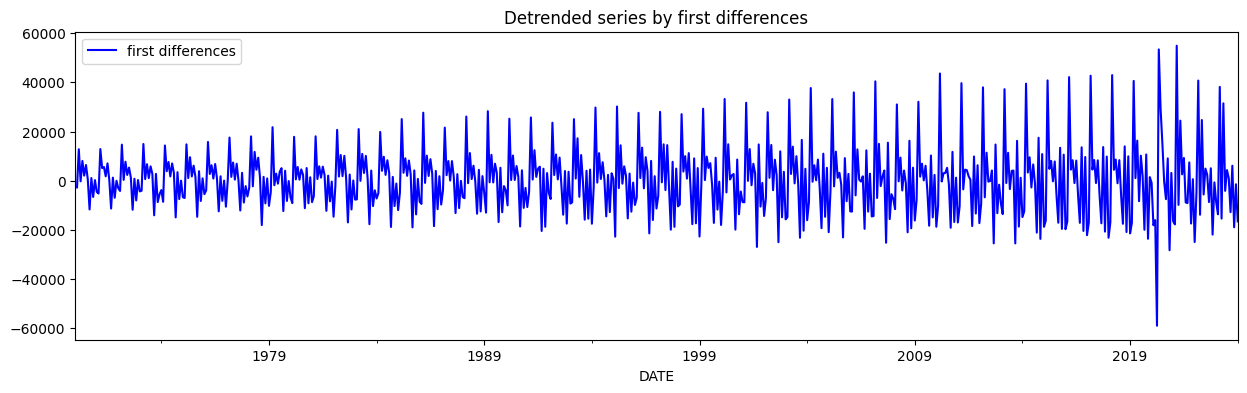

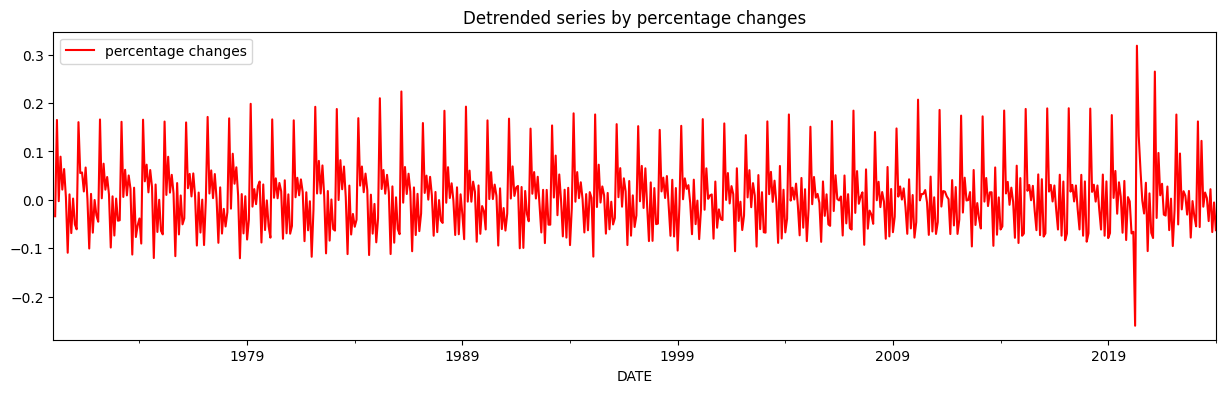

In [269]:
first_diffs = df["TRFVOLUSM227NFWA"].diff(1)
first_diffs.plot(label='first differences', figsize=(15, 4), color="blue")
plt.title('Detrended series by first differences')
plt.legend()
plt.show()

pct_changes = df['TRFVOLUSM227NFWA'].pct_change()
pct_changes.plot(label='percentage changes', figsize=(15, 4), color="red")
plt.title('Detrended series by percentage changes')
plt.legend()
plt.show()

In [270]:
def plot_rolling_stats(window_size: int, series: pd.Series, name: str) -> plt.Axes:
    """
    Plot rolling mean and standard deviation for pandas Series
    """
    series_fd = series.rolling(window_size).mean().plot(label=f"Rolling mean of {name}", figsize=(15, 4), color="blue")
    series_std = series.rolling(window_size).std().plot(label=f"Rolling standard deviation of {name}", figsize=(15, 4), color="red")
    plt.title(f"{name.capitalize()}: rolling mean and standard deviation")
    plt.legend()
    plt.show()

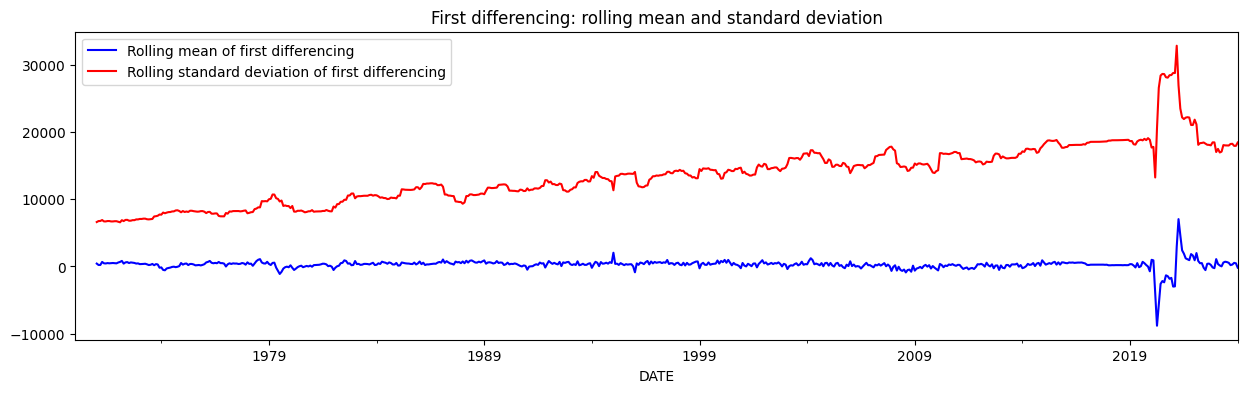

In [271]:
window_size = 12

plot_rolling_stats(window_size, first_diffs, "first differencing")

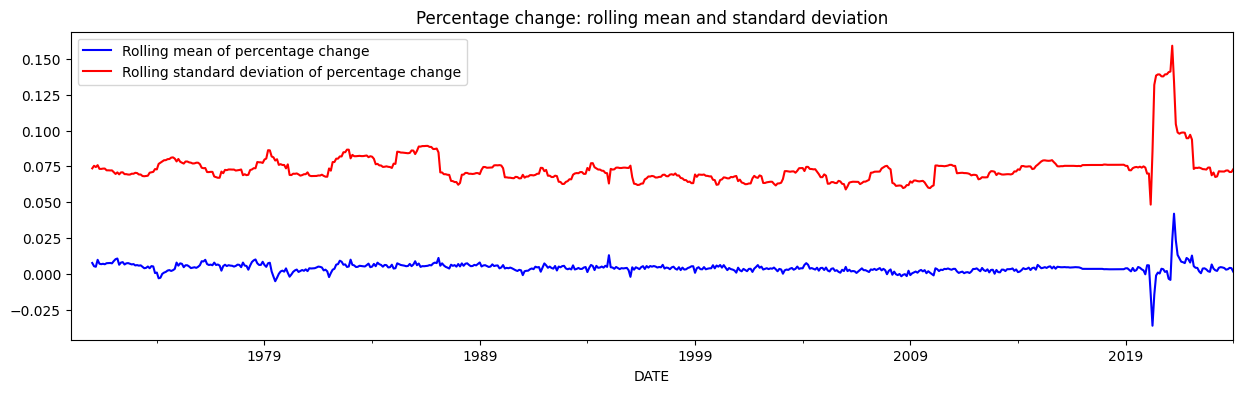

In [272]:
plot_rolling_stats(window_size, pct_changes, "percentage change")

After plotting the rolling mean and rolling standard deviation of both methods, now we can compare them.

It is clear that, rolling means, almost don't have any difference with each other (except their certainty on the y-axis). They remain "unchanged" for almost the entire interval (there are no sharp changes in value).

Standard deviations of both methods have differnet situations. The variance of the data to which the first method (first differncing) was applied seems to be unconstant, means the data has heterescedasticity. For this task it is not important, but if we want to construct a model for prediction vehicle driven miles, we will need to take it into account. There are no other significant differences in standard deviations of thess methods (except their certainty on the y-axis).

Additionally, I will check whether my assumption is true about heteroscedasticity. I will use White Test for it.

The White Test has the null hypothesis that the inputted variables have same variance or homoscedastic. So, if we get p-value lower than 0.05, we will say that our data is heteroscedastic. Also, The main input to this test is the residuals of a regression model, therefore I will need to construct OLS to perform White Test

In [273]:
first_diffs = first_diffs.dropna()
constant = sm.add_constant(np.arange(len(first_diffs)))

model = sm.OLS(first_diffs, constant).fit()

white_test = het_white(model.resid,  model.model.exog)
print(white_test[3])

9.557983506973937e-13


As we can see, the p-value is low, so we can state that my assumption is correct.

To decide whether detrending works, we can look at the first two plots in this section and check if they don't have trend.

There are no trend in these plots, so we can state, that detrending works.

If we want to know which method works better, we can use test for stationarity and check which method produce lower p-value. I create a fucntion for this purposes, which uses Augmented Dickey-Fuller Test for Stationarity.

In [274]:
def check_stationarity(series: pd.Series) -> bool:
    """
    Check whether the data is stationar
    using Augmented Dickey-Fuller Test for Stationarity
    """
    p_value = adfuller(series.dropna())[1]
    checker =  True if p_value < 0.05 else False
    
    return (p_value, checker)

In [275]:
fd_method = check_stationarity(first_diffs)
pct_method = check_stationarity(pct_changes)

if fd_method[1]:
    print("The data after applying first differencing method is stationar")
else:
    print("The data after applying first differencing method is unstationar")
print('-----------------------------------------------------------------')

if pct_method[1]:
    print("The data after applying percentage changes method is stationar")
else:
    print("The data after applying percentage changes method is unstationar")

The data after applying first differencing method is stationar
-----------------------------------------------------------------
The data after applying percentage changes method is stationar


Both methods make data stationar, it can take as one more evident that detrending works

In [276]:
if fd_method[0] < pct_method[0]:
    print("First difference method works better")
else:
    print("Percentage changes method works better")

First difference method works better


So we can state that first differencing method works better

## Task 1.4

In [277]:
df['TRFVOLUSM227NFWA_log'] = np.log(df['TRFVOLUSM227NFWA'])
df['time_int'] = range(1, df.shape[0] + 1)
df['time_int_square'] = df['time_int'] ** 2
df.head(5)

,TRFVOLUSM227NFWA,TRFVOLUSM227NFWA_log,time_int,time_int_square
DATE,,,,
1970-01-01,80173.0,11.291942,1,1
1970-02-01,77442.0,11.257285,2,4
1970-03-01,90223.0,11.410040,3,9
1970-04-01,89956.0,11.407076,4,16
1970-05-01,97972.0,11.492437,5,25


In [278]:
def get_trend_preds(data, x_names, y_name):
    data = data.dropna()
    model = LinearRegression(fit_intercept=True)
    model.fit(data[x_names], data[y_name])
    trend_preds = model.predict(data[x_names])
    trend_preds = pd.Series(trend_preds, index=data.index)
    return trend_preds

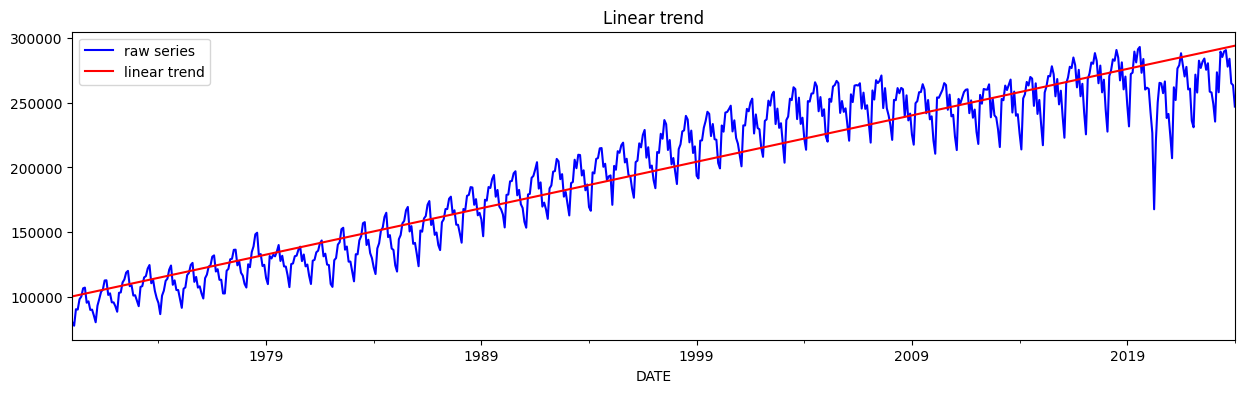

In [279]:
linear_trend = get_trend_preds(data=df.copy(), x_names=['time_int'], y_name='TRFVOLUSM227NFWA')
df['linear_trend'] = linear_trend
df['value_detrended_linearly'] = df['TRFVOLUSM227NFWA'] - df['linear_trend']

df['TRFVOLUSM227NFWA'].plot(label='raw series', color="blue")
df['linear_trend'].plot(label='linear trend', figsize=(15, 4), color="red")
plt.legend()
plt.title('Linear trend')
plt.show()

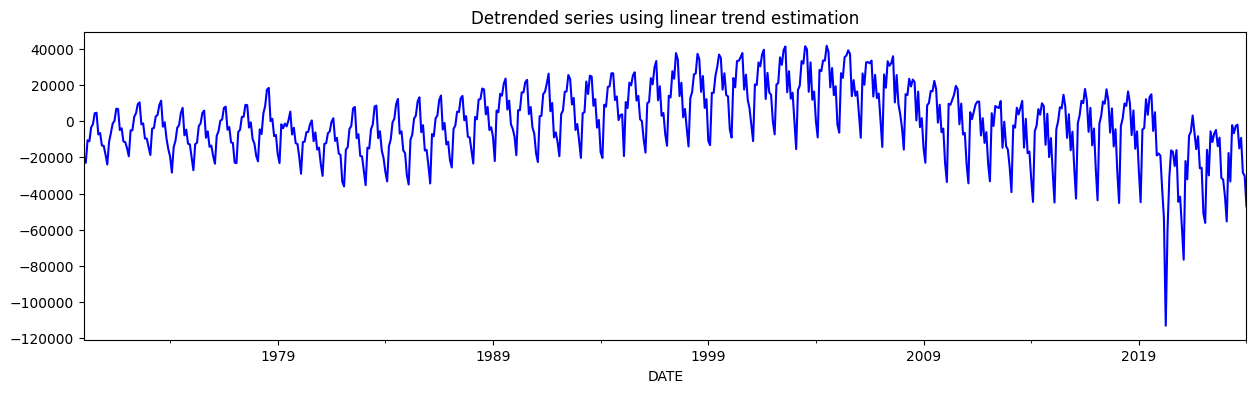

In [280]:
df['value_detrended_linearly'].plot(figsize=(15, 4),color="blue")
plt.title('Detrended series using linear trend estimation')
plt.show()

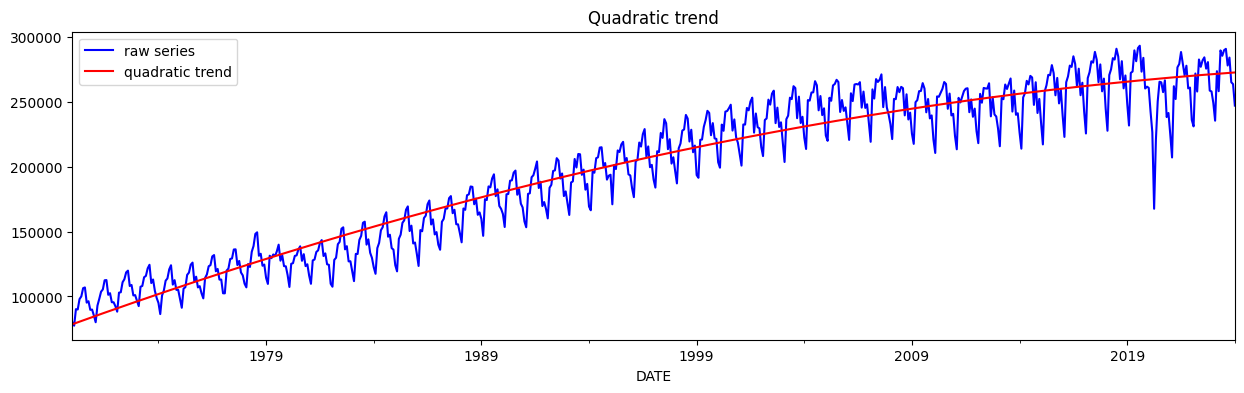

In [281]:
quadratic_trend = get_trend_preds(data=df.copy(), x_names=['time_int', 'time_int_square'], y_name='TRFVOLUSM227NFWA')
df['quadratic_trend'] = quadratic_trend
df['value_detrended_quadratically'] = df['TRFVOLUSM227NFWA'] - df['quadratic_trend']

df['TRFVOLUSM227NFWA'].plot(label='raw series', color="blue")
df['quadratic_trend'].plot(label='quadratic trend', figsize=(15,4), color="red")
plt.legend()
plt.title('Quadratic trend')
plt.show()

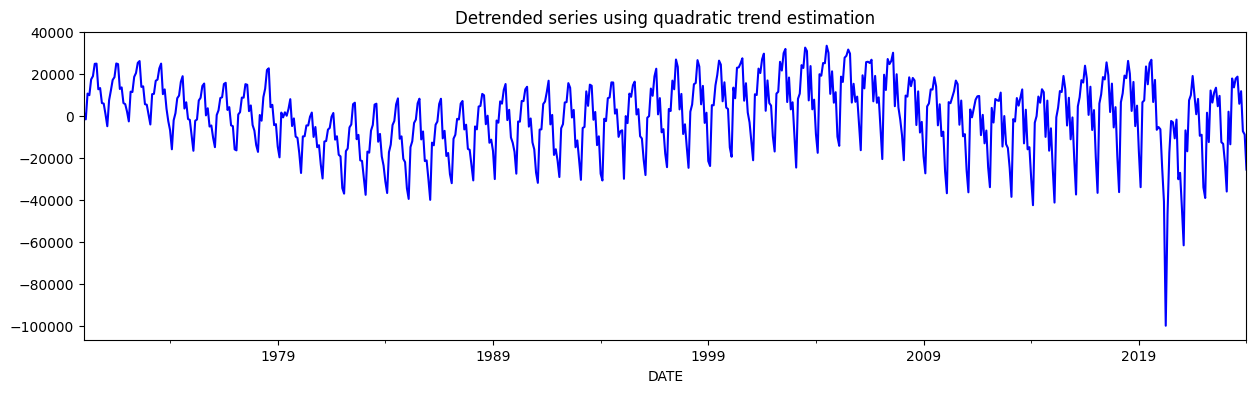

In [282]:
df['value_detrended_quadratically'].plot(figsize=(15, 4), color="blue")
plt.title('Detrended series using quadratic trend estimation')
plt.show()

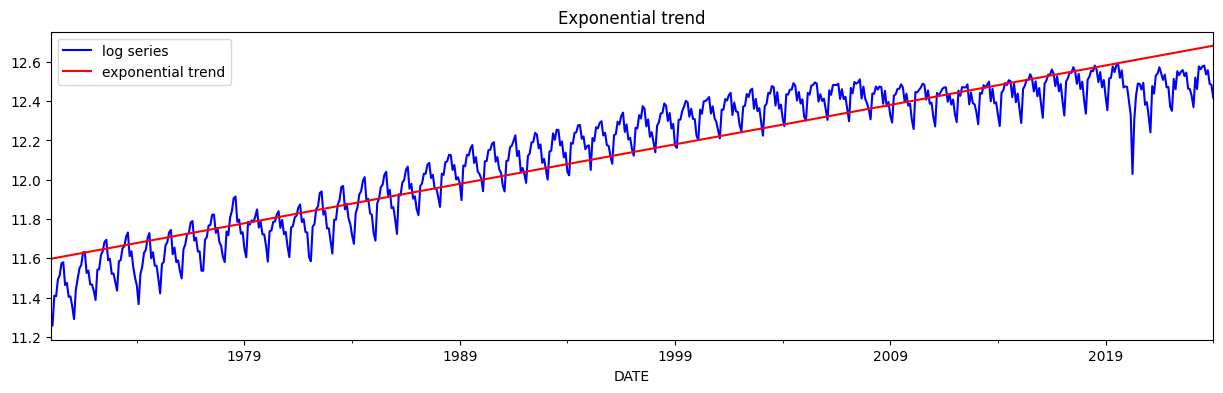

In [283]:
exponential_trend = get_trend_preds(data=df.copy(), x_names=['time_int'], y_name='TRFVOLUSM227NFWA_log')
df['exponential_trend'] = exponential_trend
df['value_log_detrended_exponentially'] = df['TRFVOLUSM227NFWA_log'] - df['exponential_trend']

df['TRFVOLUSM227NFWA_log'].plot(label='log series', color="blue")
df['exponential_trend'].plot(label='exponential trend', figsize=(15,4), color="red")
plt.legend()
plt.title('Exponential trend')
plt.show()

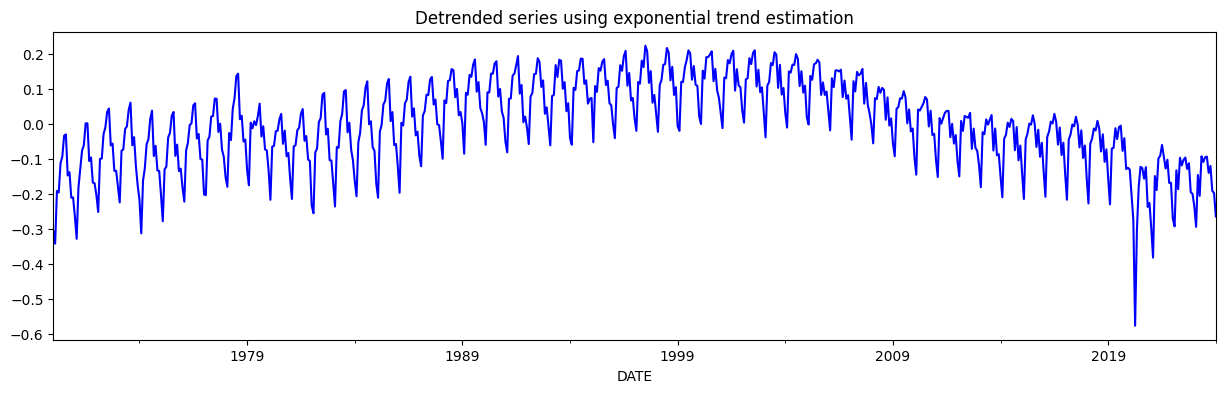

In [284]:
df['value_log_detrended_exponentially'].plot(figsize=(15, 4), color="blue")
plt.title('Detrended series using exponential trend estimation')
plt.show()

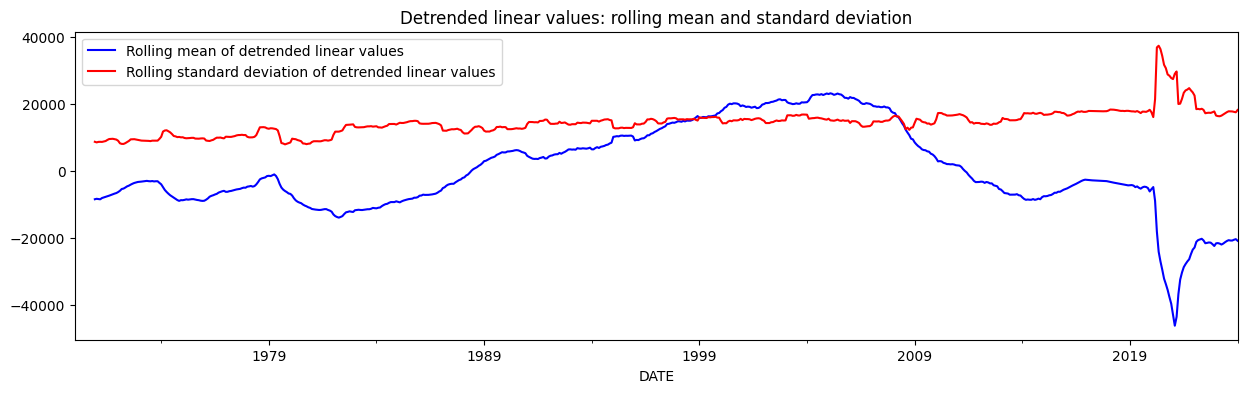

In [285]:
plot_rolling_stats(window_size, df['value_detrended_linearly'], "detrended linear values")

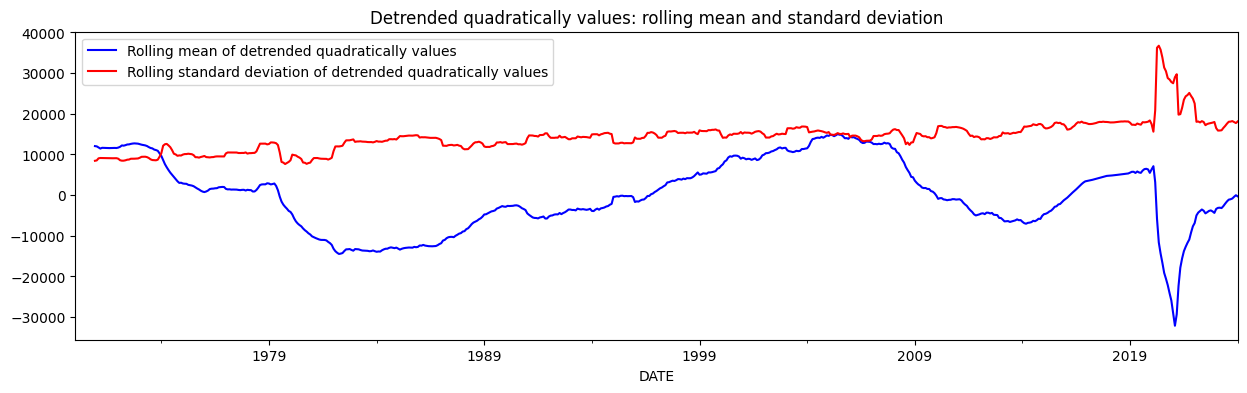

In [286]:
plot_rolling_stats(window_size, df['value_detrended_quadratically'], "detrended quadratically values")

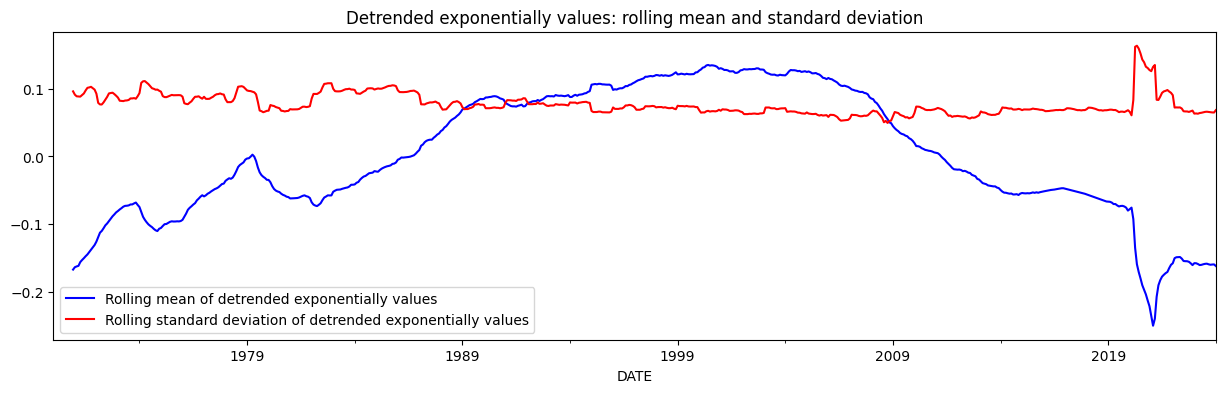

In [287]:
plot_rolling_stats(window_size, df['value_log_detrended_exponentially'], "detrended exponentially values")

Comparing these methods with the methods from the previous section, we can say that current three methods work worse.

They have unconstant rolling mean in each plot. This can be interpreted that some "parts" of trend (may be it will be better to say subtrends) still remains. It seems, that assumption from previous sentence is true. If we take a look at plots with titile "Detrended series using ...", we ill see that data values still have some tendency to increase and to decrease during all time period. For example in Detrended series using exponential trend estimation' plot, data values increase from 1970 to 2000 and decrese from 2000 to 2024 (these two periods divide all time line in two parts, so we can state that thess increasing and decreasing are two trends).

Among all three methods the most constant rolling mean has quadratic detrending and the most unconstant - exponential detrending. Also, the methods have different definiteness on the y-axis, but this does not matter in our case.

About standard deviation: all three methods have quite constant (almost constant) rolling standard deviation what can state that they produce homoskedastic data.

## Task 1.5

Additional method is **LOWESS (Locally Weighted Scatterplot Smoothing)** method.


LOWESS (Locally Weighted Scatterplot Smoothing), also known as LOESS (Locally Weighted Smoothing), is a widely-used technique in regression analysis. It generates a smooth curve on a scatter plot or time series plot, aiding in the visualization of relationships between variables and the identification of trends.

**How it works?** 

The idea is to use a subset of nearby points, called a neighborhood, to fit a Weighted least squares to each point. The size of neighborhood can be changed to achieve the best curve (parameter $frac$ is stand for ration between neighborhood and all data). Also, the smaller neighborhood is, the more information we lose from our data.

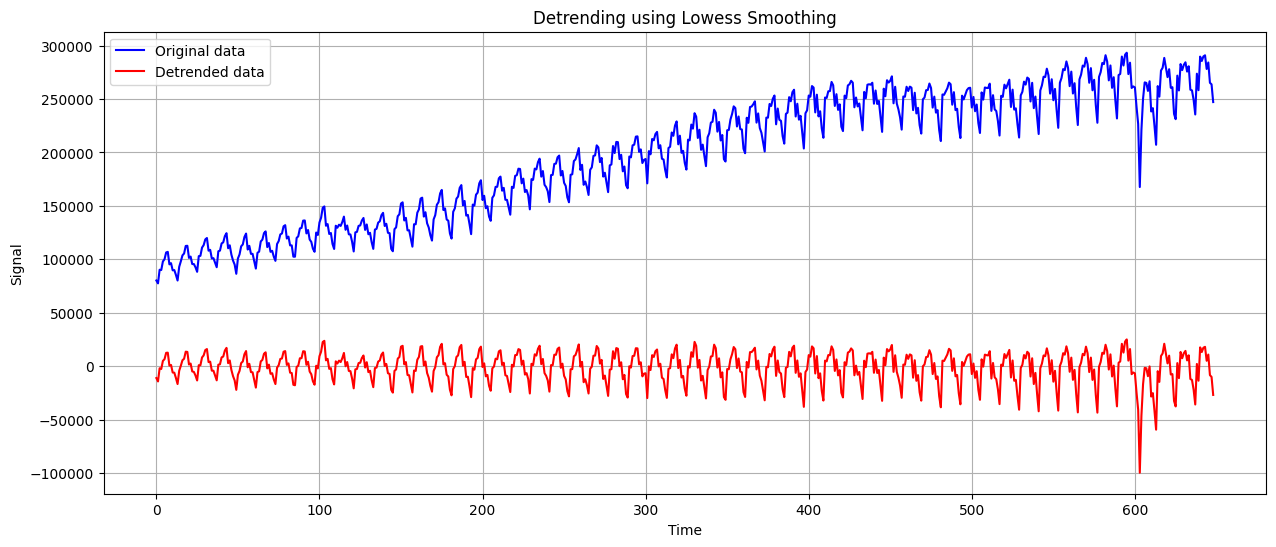

In [288]:
lowess = sm.nonparametric.lowess(df['TRFVOLUSM227NFWA'], np.arange(len(df['TRFVOLUSM227NFWA'])), frac=0.11)

smoothed_values = lowess[:, 1]

detrended_data = df['TRFVOLUSM227NFWA'] - smoothed_values

plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(df['TRFVOLUSM227NFWA'])), df['TRFVOLUSM227NFWA'], label='Original data', color="blue")
plt.plot(np.arange(len(df['TRFVOLUSM227NFWA'])), detrended_data, label='Detrended data', color="red")
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Detrending using Lowess Smoothing')
plt.legend()
plt.grid(True)
plt.show()

Experimentally, it turned out that 0.1 is the best value for $frac$ to achieve the best curve for our data. In the next section we will compare all methods and decide which method is the best.

## Task 1.6

To check whether a time series is stationary, unit root tests are commonly employed. The Augmented Dickey-Fuller (ADF) test is one such widely used method. In the ADF test, the null hypothesis ($H_0$) is that the time series contains a unit root and is thus non-stationary. This test checks whether data are stationar (without trend).

$$
H_0: \textnormal{Series is not stationar} \\
H_1: \textnormal{Series is stationar} \\
$$

Intuitively, for all methods we will reject $H_0$, so to decide which method performs the best, we will compare their p-values and method with the lowest p-value will be the best.

In [289]:
df_pval = pd.DataFrame({"Method name" : [], "P-value": []})

methods = ["First differencing", "Percent changes", "Linear detrending","Quadratic detrending", "Exponential detrending", "LOWESS method"]
methods_n = [first_diffs, pct_changes, df["value_detrended_linearly"], df["value_detrended_quadratically"], df["value_log_detrended_exponentially"], detrended_data]

for i in range(len(methods)):
    df_pval.loc[i, "Method name"] = methods[i]
    df_pval.loc[i, "P-value"] = adfuller(methods_n[i].dropna())[1]

df_pval.sort_values(by="P-value")

,Method name,P-value
0,First differencing,2.824637e-10
5,LOWESS method,7.957331e-09
1,Percent changes,7.071262e-08
3,Quadratic detrending,4.479711e-02
2,Linear detrending,5.666427e-01
4,Exponential detrending,6.894715e-01


From table, we can see that First differencing method performs detrending the best and Exponential detrending performs detrending the worst. Also Linear detrending and Exponential detrending reveals to produce non-stationar data for our experiment.

## Task 2.1

In [290]:
def plot_the_interval(series: pd.Series, lower: int, upper: int) -> plt.Axes:
    """
    Plot the specific interval
    """
    series[lower:upper].plot(figsize=(15,4), color="blue")
    plt.title(f"From {1970 + lower//12} year to {1970 + upper//12} year")

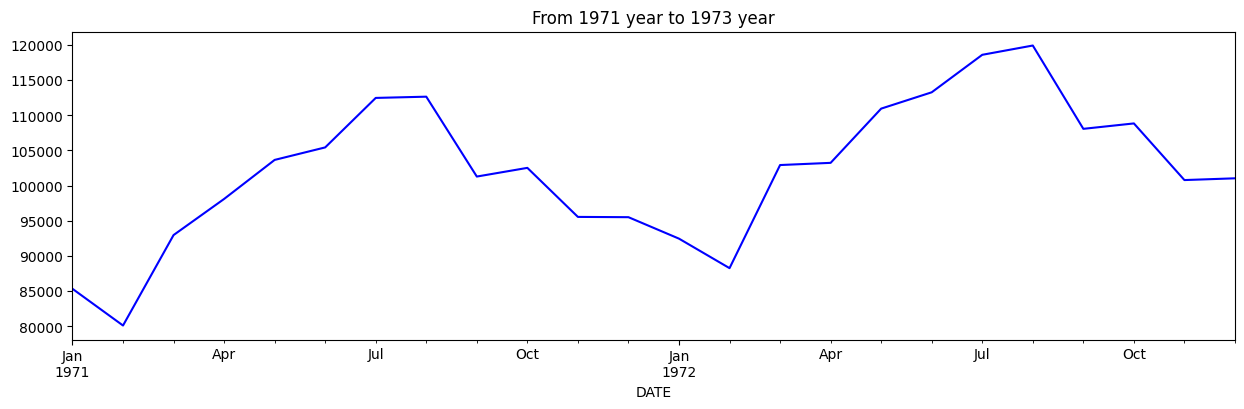

In [291]:
plot_the_interval(df["TRFVOLUSM227NFWA"],12,36)

The same as in section 1.1, to state that the data has seasonality, firstly, we need to understand, what the seasonality is. **Seasonality** is the regular and predictable patterns of change that occur at consistent intervals within each calendar year.

To find seasonality we need to divide our timeline into smaller timelines, and check whether they have some identical pattern. So, in the above plot, is shown time period from 1971 to 1973 (2 years, because end point is 1973 Jan) and it is clear, that our data has a pattern (growth from February to July and decrease from July to February each year). It means our data has seasonality.

## Task 2.2

Ignoring or removing seasonality in a time-series dataset is essential for understanding its core trends and patterns. Seasonality can create a false picture of situation. For example, when comparing ice cream prices between winter and summer, it's crucial to consider seasonality. Summer prices are usually higher because more people buy ice cream then, not because the ice cream itself is more valuable. Recognizing and adjusting for seasonality helps us see the real story in the data.

Additionally, seasonality can impact the precision of predictive models, making it necessary to address or account for its effects to improve model accuracy.

Many statistical methods and models assume that data stay the same over time. But seasonality breaks this rule by adding regular, repeating changes. So, when we remove seasonality from data, we make it more stable and consistent.

**The ways to exlude seasonality**

Firstly, we can remove seasonality if we add to our model a special dummy variables which will represent each season. In our case, It is clear that seasonality depends on monthes, so we will need to add to dataframe 12 columns, where each column represent each month. For example, in column is_january we will have 1 - if it really January and 0 - otherwise.

Secondly, we can use moving averages to remove seasonality. This method involves computing average value in window size. It will smooth the data and rmeove the seasonal component from it. For our case, it is good to take the size of window equal to 12, because it is the interval which fully contain repeating pattern.

Another approach is to use autoregressive integrated moving average (ARIMA), which can handle both short-term and long-term variations in time series data, including seasonal effects, without directly removing them from the observations. ARIMA models offer improved forecasting accuracy compared to simple deseasonalization methods because they do not rely on specific assumptions about the consistency of seasonal patterns over time.

## Task 2.3

In [292]:
df

,TRFVOLUSM227NFWA,TRFVOLUSM227NFWA_log,time_int,time_int_square,linear_trend,value_detrended_linearly,quadratic_trend,value_detrended_quadratically,exponential_trend,value_log_detrended_exponentially
DATE,,,,,,,,,,
1970-01-01,80173.0,11.291942,1,1,100167.253678,-19994.253678,78577.053296,1595.946704,11.597766,-0.305823
1970-02-01,77442.0,11.257285,2,4,100466.794849,-23024.794849,79076.503730,-1634.503730,11.599439,-0.342154
1970-03-01,90223.0,11.410040,3,9,100766.336021,-10543.336021,79575.336206,10647.663794,11.601111,-0.191072
1970-04-01,89956.0,11.407076,4,16,101065.877192,-11109.877192,80073.550726,9882.449274,11.602784,-0.195708
1970-05-01,97972.0,11.492437,5,25,101365.418364,-3393.418364,80571.147287,17400.852713,11.604457,-0.112020
...,...,...,...,...,...,...,...,...,...,...
2023-09-01,278073.0,12.535639,645,416025,293071.768077,-14998.768077,272277.497001,5795.502999,12.675132,-0.139493
2023-10-01,284151.0,12.557261,646,417316,293371.309249,-9220.309249,272378.982782,11772.017218,12.676805,-0.119544
2023-11-01,265178.0,12.488157,647,418609,293670.850420,-28492.850420,272479.850606,-7301.850606,12.678478,-0.190321


In [293]:
df_d = pd.get_dummies(df.index.month, drop_first=True)
df_d.index = df.index
dff = pd.concat([df, df_d], axis=1)
dff[[i for i in range(2,13)]] = dff[[i for i in range(2,13)]].astype(int)

dff

,TRFVOLUSM227NFWA,TRFVOLUSM227NFWA_log,time_int,time_int_square,linear_trend,value_detrended_linearly,quadratic_trend,value_detrended_quadratically,exponential_trend,value_log_detrended_exponentially,...,3,4,5,6,7,8,9,10,11,12
DATE,,,,,,,,,,,,,,,,,,,,,
1970-01-01,80173.0,11.291942,1,1,100167.253678,-19994.253678,78577.053296,1595.946704,11.597766,-0.305823,...,0,0,0,0,0,0,0,0,0,0
1970-02-01,77442.0,11.257285,2,4,100466.794849,-23024.794849,79076.503730,-1634.503730,11.599439,-0.342154,...,0,0,0,0,0,0,0,0,0,0
1970-03-01,90223.0,11.410040,3,9,100766.336021,-10543.336021,79575.336206,10647.663794,11.601111,-0.191072,...,1,0,0,0,0,0,0,0,0,0
1970-04-01,89956.0,11.407076,4,16,101065.877192,-11109.877192,80073.550726,9882.449274,11.602784,-0.195708,...,0,1,0,0,0,0,0,0,0,0
1970-05-01,97972.0,11.492437,5,25,101365.418364,-3393.418364,80571.147287,17400.852713,11.604457,-0.112020,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,278073.0,12.535639,645,416025,293071.768077,-14998.768077,272277.497001,5795.502999,12.675132,-0.139493,...,0,0,0,0,0,0,1,0,0,0
2023-10-01,284151.0,12.557261,646,417316,293371.309249,-9220.309249,272378.982782,11772.017218,12.676805,-0.119544,...,0,0,0,0,0,0,0,1,0,0
2023-11-01,265178.0,12.488157,647,418609,293670.850420,-28492.850420,272479.850606,-7301.850606,12.678478,-0.190321,...,0,0,0,0,0,0,0,0,1,0


In [305]:
dff['fd'] = first_diffs

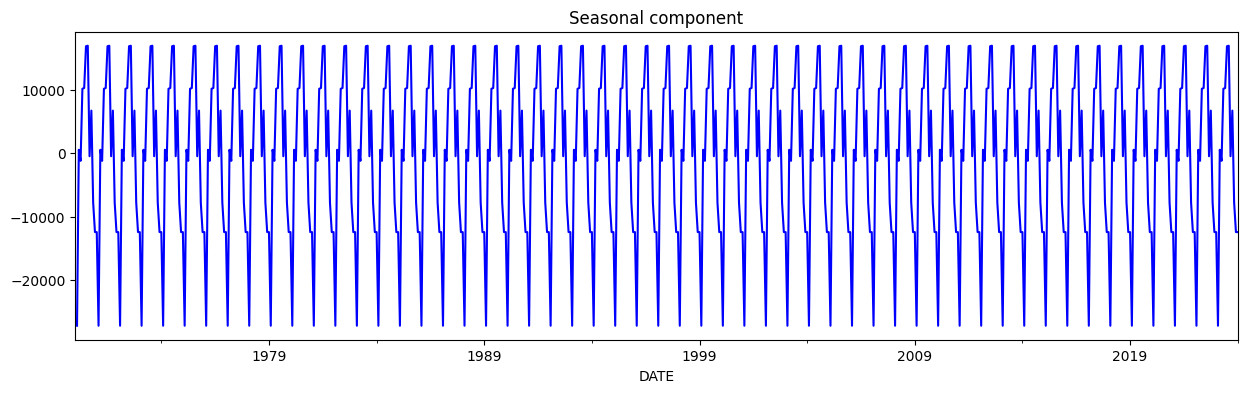

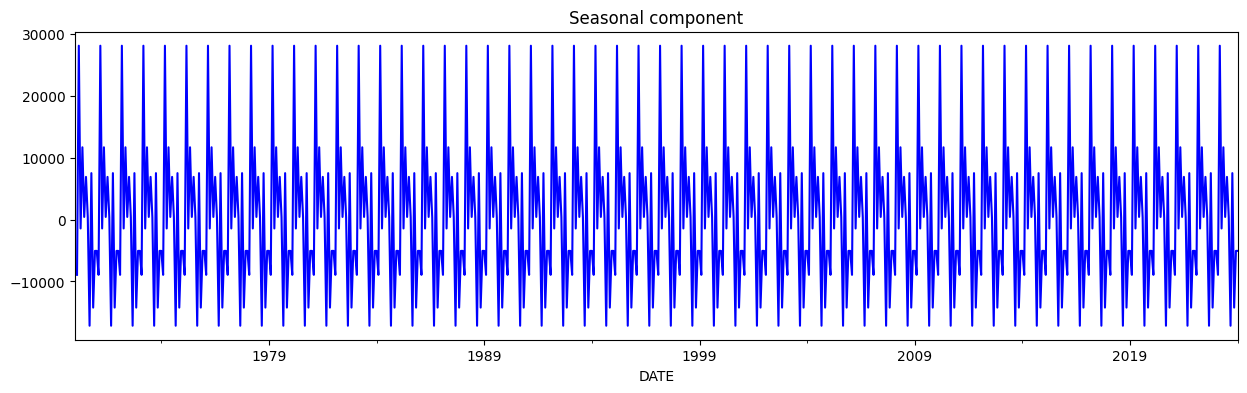

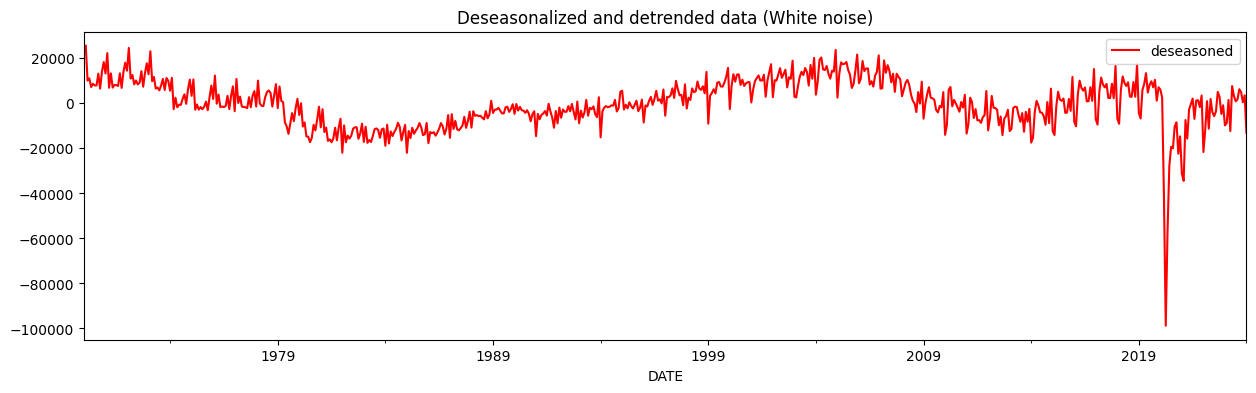

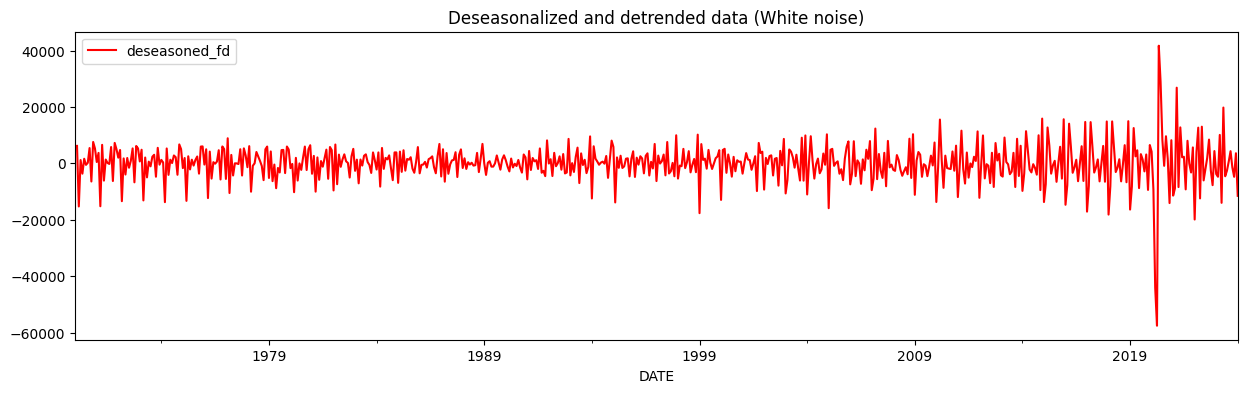

In [308]:
q_detrended_seasonal_component = get_trend_preds(data=dff.copy(),
                                                 x_names=[i for i in range(2,13)][:-1],
                                                 y_name='value_detrended_quadratically')
dff['seasonal_component'] = q_detrended_seasonal_component
dff['deseasoned'] = dff['value_detrended_quadratically'] - \
    dff['seasonal_component']

fd_detrended_seasonal_component = get_trend_preds(data=dff.copy(),
                                                 x_names=[i for i in range(2,13)][:-1],
                                                 y_name='fd')
dff['seasonal_component_fd'] = fd_detrended_seasonal_component
dff['deseasoned_fd'] = dff['fd'] - \
    dff['seasonal_component_fd']

dff['seasonal_component'].plot(figsize=(15, 4), color="blue")
plt.title('Seasonal component')
plt.show()

dff['seasonal_component_fd'].plot(figsize=(15, 4), color="blue")
plt.title('Seasonal component')
plt.show()

dff['deseasoned'].plot(figsize=(15, 4), color="red")
plt.title('Deseasonalized and detrended data (White noise)')
plt.legend()
plt.show()

dff['deseasoned_fd'].plot(figsize=(15, 4), color="red")
plt.title('Deseasonalized and detrended data (White noise)')
plt.legend()
plt.show()

Our result is data without trend and seasonality. Only white noise is left. 

To obtain such results we add seasonal dummy variable to dataframe. Seasonal component is get by using quadratic detrended data and data obtained from first differencing method, because first (quadratic) is the best among all three methods in section 1.4 and second (first differencing) is the best among all methods in this work (it is the most stationar among them).